In [1]:
import random
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_s800_time(names):
    return [ 6.25 * float(el.split('_')[1][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[:,i]) for i in range(sc_data.shape[1])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    plt.scatter(df.iloc[row_num,:], time)
    
def dist(x, y):
    # TODO normed difference
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    
    return (x-y).T@(x-y)


"""
    this implementation of k-means takes as input (i) a matrix pd
    with the data points as rows (ii) an integer K representing the number 
    of clusters, and returns (i) a matrix with the K rows representing 
    the cluster centers 
    """
def k_means_from_pd_data(pd, K, maxIters = 300):
   
    centroids = pd[np.random.choice(pd.shape[0], K, replace=False)]
    old_centroids = centroids.copy()
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([dist(x_i, y_k) for y_k in centroids]) for x_i in pd])
        # Update centroids step
        for k in range(K):
            if (C == k).any():                
                centroids[k] = pd[C == k].mean(axis = 0) 
            else: # if there are no data points assigned to this certain centroid
                centroids[k] = pd[np.random.choice(len(pd))] 
        if np.array_equal(centroids, old_centroids):
            print(f'converged on iter: {i}')
            break
        old_centroids = centroids.copy()
    return C, centroids

def add_top_n_expressed_label_to_var(data,top_n):
    cutoff = sorted(data.var.n_counts, reverse=True)[top_n]

    for i in range(0, data.var.shape[0]):
        if data.var.iloc[i,:].n_counts > cutoff:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = True
        else:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = False
    
def drop_description(old_file, new_file):
    df = pd.read_csv(old_file, sep='\t', index_col=0)
    df = df.drop(['description'], axis=1)
    df.to_csv(new_file, sep='\t')

In [89]:

s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)

sc.pp.normalize_total(s814_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s814_adata)
sc.pp.filter_genes(s814_adata, min_counts=1)


add_top_n_expressed_label_to_var(s814_adata,50)
#print(s814_adata[:,1:3])
#print(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])])
#print(type(s814_adata.var.top_n_expressed))

#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s814_pd = get_periodgram(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])]) 
s814_pd_array = np.array([i[1] for i in s814_pd])
#print(len(s814_pd))



[[3.2424434e-12 1.2278847e+00 7.8285359e-02 ... 4.5691884e-01
  5.3061491e-01 2.6881349e-01]
 [1.6010897e-12 5.2934694e-01 4.4609006e-02 ... 9.4518922e-03
  5.6967787e-03 1.5972763e-02]
 [1.2748085e-10 2.0583837e+00 1.0407112e+00 ... 9.9298231e-02
  1.5963960e-02 7.9671131e-04]
 ...
 [4.3793120e-12 1.2338877e+00 2.8399250e-01 ... 5.4004872e-01
  2.9137152e-01 1.4173931e-01]
 [6.1604055e-12 3.0336704e+00 6.0110718e-02 ... 2.2169927e-01
  2.7738905e-02 2.2809049e-01]
 [2.9710161e-11 5.3601481e-02 6.1597493e-02 ... 4.5495532e-02
  5.8650166e-02 7.0393652e-02]]


In [3]:
K = 6
C, centroids = k_means_from_pd_data(s814_pd_array,K)

print('C = \n', C)

converged on iter: 4
C = 
 [3 1 1 5 5 0 0 2 4 1 5 3 3 5 3 0 3 1 3 0 0 3 3 5 1 3 4 0 1 0 1 3 0 1 1 3 4
 1 3 1 1 4 1 3 4 5 5 3 0 3]


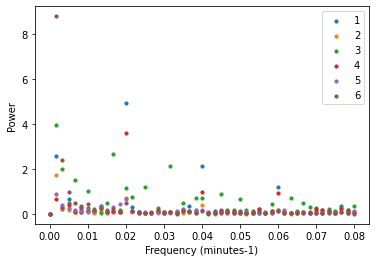

0.01

In [4]:

#matplotlib.pyplot.scatter(s814_pd[0][0],centroids_2[1])
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s814_pd[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )


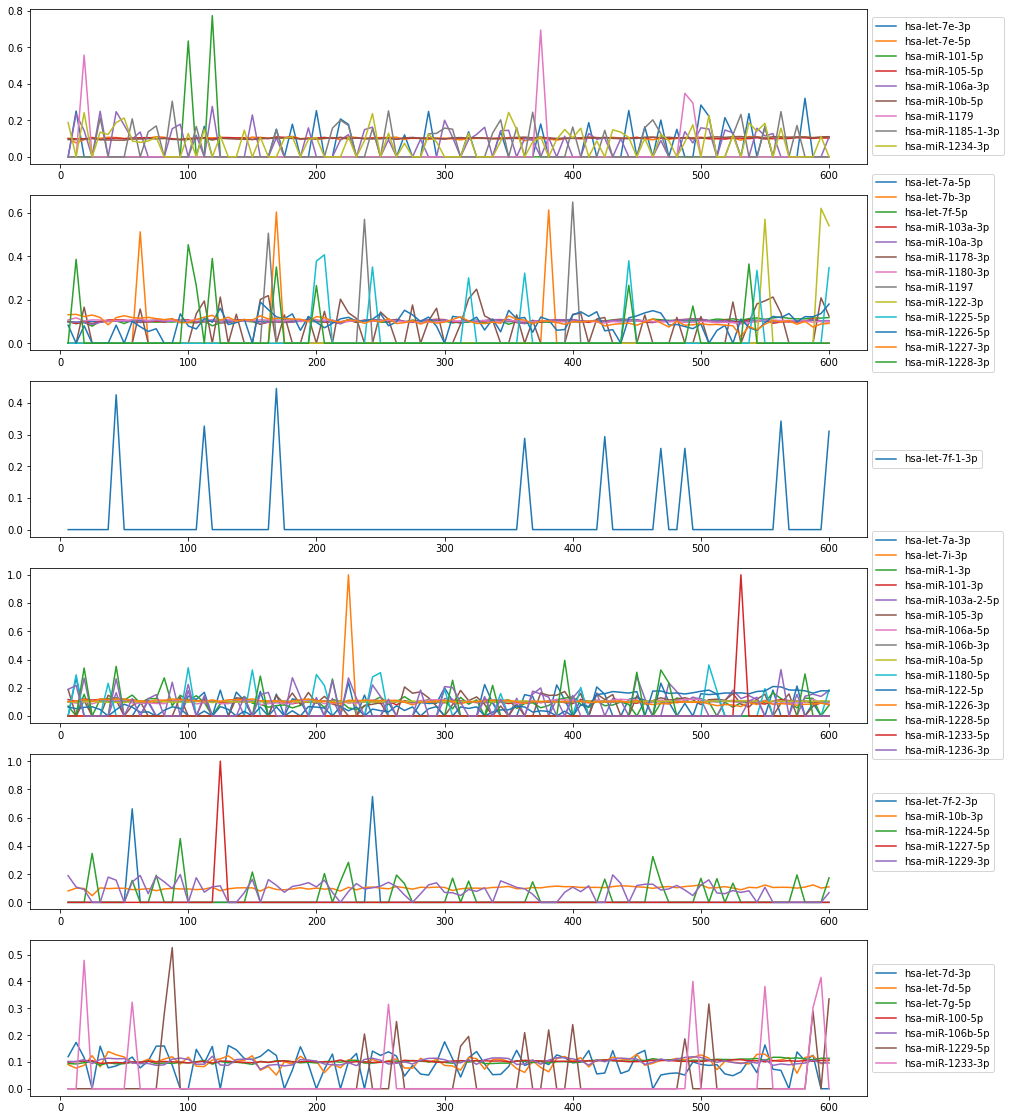

In [5]:

fig, axs = plt.subplots(K,1, figsize=(15,20))

time = s814_adata.obs.time

for i_k in range(K):
    for i in range(len(C)):
        if C[i]==i_k:
            y = s814_adata.X[:,i]
            axs[i_k].plot(time,y/np.linalg.norm(y), label=s814_adata.var.index[i].split(',')[0])
            axs[i_k].legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
#plt.ylabel('Power')

#plt.legend();
#plt.show();

#for i in range(10):
   # matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

In [102]:
s800_adata = sc.read("data/s800.tab").T

s800_adata.obs['time'] = get_s800_time(s800_adata.obs.index)

sc.pp.normalize_total(s800_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s800_adata)
sc.pp.filter_genes(s800_adata, min_counts=1)


add_top_n_expressed_label_to_var(s800_adata,200)
s800_top = s800_adata[:,s800_adata.var.top_n_expressed.isin([True])]
#print(s814_adata[:,1:3])
#print(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])])
#print(type(s814_adata.var.top_n_expressed))

#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s800_pd = get_periodgram(s800_top) 
s800_pd_array = np.array([i[1] for i in s800_pd])


[[3.4200791e-12 5.7203484e-01 7.8132115e-02 ... 6.3053571e-02
  1.1571975e-01 3.3303684e-01]
 [5.4003618e-11 1.1137776e-01 2.8479278e-01 ... 2.9324375e-02
  2.8324953e-01 4.9530849e-01]
 [5.6902632e-11 2.8616601e-01 3.3299577e-01 ... 3.9779395e-02
  1.2741677e-01 2.4308143e-02]
 ...
 [2.1316282e-12 1.2210622e+00 2.2106138e-01 ... 3.6382921e-02
  2.2887900e-01 1.1305141e-01]
 [2.5792701e-12 2.8765675e-02 4.8836349e-03 ... 6.0147382e-02
  4.2790186e-02 1.3165551e-02]
 [5.6867107e-12 6.3043201e-01 5.4835886e-02 ... 1.5614914e-02
  8.3851360e-02 9.2887217e-03]]


In [168]:
# Find the cluster which has 10-5p guy.
# for each gene in s800_pd, find the distance from pd_gene_i, sort, pick 20 closest.
position_of_10a_5p = list(s814_adata.var.index).index('hsa-miR-10a-5p')
# index in anndata.var means gene names
# but list data type also has a function, called index(), which returns position
Centroid_label_with_10a_5p = C[position_of_10a_5p]
Centroid_values_for_10a_5p = centroids[Centroid_label_with_10a_5p]
print(position_of_10a_5p)
#print( Centroid_values_for_10a_5p )
#s800.var['dist_to_10a_5p_cluster'] = ... 


s800_top.var['dist'] = np.nan
for i in range(len(s800_pd)):
    s800_top.var.loc[s800_top.var.index[i], 'dist'] = dist(s814_pd_array[25],s800_pd_array[i])
    


cutoff = sorted(s800_top.var.dist, reverse=False)[50]
s800_20 = s800_top[:,s800_top.var.dist < cutoff]
print(s800_20.var)


25
           n_counts top_n_expressed      dist
CALM2    672.031494            True  0.241593
CANX     658.957581            True  0.239909
CCDC72   637.835449            True  0.141241
CCT8     651.822876            True  0.156738
CSDE1    663.356384            True  0.192988
EIF3E    676.784058            True  0.194499
EIF4B    637.730835            True  0.205452
EIF4G2   642.373474            True  0.213293
HMGN1    844.313599            True  0.320536
HMGN2    647.759888            True  0.223653
LAPTM4B  728.492554            True  0.249702
LDHB     784.871704            True  0.175337
LIN28A   642.145203            True  0.245167
MORF4L1  640.215271            True  0.122823
MRFAP1   669.903687            True  0.352290
MYL6     781.801331            True  0.322522
NACA     700.954590            True  0.294670
NAP1L1   746.396118            True  0.309145
NPM1     933.309082            True  0.343255
NTS      665.331787            True  0.131670
PABPC1   816.202271            

In [151]:

s745_adata = sc.read("data/sub_0745_miRNA.ec.tab").T


s745_adata_first_run = s745_adata[::2]
s745_adata_second_run = s745_adata[1::2]


s745_adata_first_run.obs['time'] = get_s745_time(s745_adata.obs.index[::2])
s745_adata_second_run.obs['time'] = get_s745_time(s745_adata.obs.index[1::2])

sc.pp.normalize_total(s745_adata_first_run, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s745_adata_first_run)
sc.pp.filter_genes(s745_adata_first_run, min_counts=1)

sc.pp.normalize_total(s745_adata_second_run, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s745_adata_second_run)
sc.pp.filter_genes(s745_adata_second_run, min_counts=1)



#add_top_n_expressed_label_to_var(s745_adata,50)
add_top_n_expressed_label_to_var(s745_adata_first_run,50)
add_top_n_expressed_label_to_var(s745_adata_second_run,50)


s745_pd_first_run= get_periodgram(s745_adata_first_run[:,s745_adata_first_run.var.top_n_expressed.isin([True])])
s745_pd_second_run= get_periodgram(s745_adata_second_run[:,s745_adata_second_run.var.top_n_expressed.isin([True])])

s745_pd_array_first = np.array([i[1] for i in s745_pd_first_run])
s745_pd_array_second = np.array([i[1] for i in s745_pd_second_run])


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


(96,)
(96,)


In [78]:
K = 6
C, centroids = k_means_from_pd_data(s745_pd_array_first,K)

print('C = \n', C)

converged on iter: 2
C = 
 [3 3 5 2 4 4 2 3 2 2 4 0 0 4 2 0 5 0 2 5 0 3 1 4 2 0 4 3 2 4 2 2 4 2 3 4 4
 4 2 4 2 0 4 2 2 4 3 1 4 3]


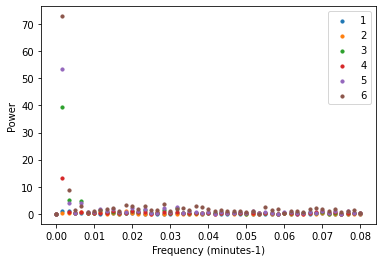

In [80]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s745_pd_first_run[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();




In [162]:

drop_description("data/sub_0743.genes.no_mt.tpm.rescale.tab", "data/s743.tab")
s743_adata = sc.read("data/s743.tab").T

s743_adata.obs['time'] = get_s745_time(s743_adata.obs.index)

sc.pp.normalize_total(s743_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s743_adata)
sc.pp.filter_genes(s743_adata, min_counts=1)


add_top_n_expressed_label_to_var(s743_adata,200)
s743_top = s743_adata[:,s743_adata.var.top_n_expressed.isin([True])]

s743_pd = get_periodgram(s743_top) 
s743_pd_array = np.array([i[1] for i in s743_pd])




In [167]:
position_of_10a_5p_first = list(s745_adata_first_run.var.index).index('hsa-miR-10a-5p')
# index in anndata.var means gene names
# but list data type also has a function, called index(), which returns position
Centroid_label_with_10a_5p = C[position_of_10a_5p]
Centroid_values_for_10a_5p = centroids[Centroid_label_with_10a_5p]

#print( Centroid_values_for_10a_5p )
#s800.var['dist_to_10a_5p_cluster'] = ... 

# 2N -> N + 1 in periodogram
# 96 time points -> 49
# but in 743 they were duplicated! 
# so we need to make 2 'views' but this time we will split on obs, not var

#s745_pd_first_run = s745_adata[:,s745_adata.obs[::2]]
#s745_pd_second_run = s745_adata[:,s745_adata.obs[1::2]]

# my_new_array= old_array[ < row xpresssion> , <col expression>] 
# not the case for this wacky anndata object! onlty need one, and it detects what type of indexer 
# .loc then it uses both - going behind the scenes and using pandas, becasue .loc is a pandas indexer.


s743_top.var['dist'] = np.nan
for i in range(len(s743_pd)):
    s743_top.var.loc[s743_top.var.index[i], 'dist'] = dist(
        s745_pd_array_first[position_of_10a_5p_first],s743_pd_array[i]
    )
    


cutoff = sorted(s743_top.var.dist, reverse=False)[50]
s743_20 = s743_top[:,s743_top.var.dist < cutoff]
print(s743_20.var)


#SCD,HSP90B1

            n_counts top_n_expressed      dist
CLIC1     652.062134            True  0.130343
COL1A2    677.180542            True  0.017810
CTHRC1    646.095093            True  0.019350
DBI       777.063538            True  0.155207
DBN1      650.049072            True  0.066128
DNAJA1    642.939697            True  0.019236
EEF1B2    685.188354            True  0.036271
EEF2      725.747253            True  0.084176
EIF4A2    652.306213            True  0.028157
FABP5     656.730469            True  0.044435
FDPS      673.030151            True  0.024173
FTL       672.846497            True  0.096727
H2AFZ     657.734253            True  0.036361
HMGB1     702.315552            True  0.078567
HMGB2     743.402588            True  0.066840
HMGCS1    719.585693            True  0.095704
HNRNPD    694.457458            True  0.088067
HNRNPH1   719.047119            True  0.030425
HNRNPM    707.330078            True  0.031615
HSP90B1   749.931580            True  0.027678
HSPA5     664

In [169]:
position_of_10a_5p_second = list(s745_adata_second_run.var.index).index('hsa-miR-10a-5p')

s743_top.var['dist'] = np.nan
for i in range(len(s743_pd)):
    s743_top.var.loc[s743_top.var.index[i], 'dist'] = dist(
        s745_pd_array_second[position_of_10a_5p_second],s743_pd_array[i]
    )
    


cutoff = sorted(s743_top.var.dist, reverse=False)[50]
s743_20_second = s743_top[:,s743_top.var.dist < cutoff]
print(s743_20_second.var)


            n_counts top_n_expressed      dist
ACTB      748.611084            True  0.200786
CLIC1     652.062134            True  0.224142
CTHRC1    646.095093            True  0.217953
DBI       777.063538            True  0.162605
DBN1      650.049072            True  0.212562
DLL1      833.599182            True  0.207722
EEF1B2    685.188354            True  0.219877
EEF1G     792.668213            True  0.164608
EEF2      725.747253            True  0.216054
FABP5     656.730469            True  0.204077
FDPS      673.030151            True  0.209230
FTL       672.846497            True  0.176274
H2AFZ     657.734253            True  0.187435
HMGB1     702.315552            True  0.194414
HMGB2     743.402588            True  0.205057
HNRNPD    694.457458            True  0.220816
HNRNPM    707.330078            True  0.208282
HSP90B1   749.931580            True  0.205518
KRT8      674.239502            True  0.200259
MEST      767.490479            True  0.215613
MTRNR2L2  663

In [176]:
s743_20_second.var.index.shape[0]

50

In [181]:
repeat_gene_array = []
for i in range(s743_20_second.var.index.shape[0]):
    for j in range(s743_20.var.index.shape[0]):
        for k in range(s800_20.var.index.shape[0]):
            if s743_20_second.var.index[i] == s743_20.var.index[j]:
                if(s743_20_second.var.index[i] == s800_20.var.index[k]):
                    repeat_gene_array.append(s743_20_second.var.index[i])
        
print(repeat_gene_array)

['NPM1', 'RBMX', 'RCN1', 'RPS21', 'RPS4Y1', 'RPS6']


In [ ]:
#none of them are defined target for hsa-miR-10a-5p based on miRDA database